In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

In [4]:
sheet = pd.read_excel('data_input_auto/煤油裂解价差.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['新加坡航空煤油裂解价差'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=21, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,新加坡航空煤油裂解价差,布伦特迪拜掉期 EFS,新加坡航空煤油裂解价差拟合残差/布伦特迪拜掉期 EFS（路透）
2025-09-26,NaN,NaN,NaN
2025-09-29,NaN,NaN,NaN
2025-09-30,NaN,NaN,NaN
2025-10-01,NaN,NaN,NaN
2025-10-02,NaN,NaN,NaN


In [5]:
file_path1 = os.path.expanduser("eta/煤油裂解价差拟合残差_布伦特迪拜_合并数据.xlsx") 
sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1 = sheet1.drop(columns=['真实值'])
sheet1 = sheet1.dropna()
sheet1 = sheet1.sort_values('Date', ascending=True)
sheet1.head()

,Date,预测值
20,2025-09-04,-4.1
19,2025-09-05,-7.4
18,2025-09-08,-5.8
17,2025-09-09,-7.2
16,2025-09-10,-6.9


In [6]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['新加坡航空煤油裂解价差拟合残差/布伦特迪拜掉期 EFS（路透）'] = sheet_daily['新加坡航空煤油裂解价差拟合残差/布伦特迪拜掉期 EFS（路透）'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')
sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-03-01')]

In [7]:
sheet_daily['布伦特迪拜掉期 EFS_提前72天'] = sheet_daily['布伦特迪拜掉期 EFS'].shift(72)
sheet_daily['新加坡航空煤油裂解价差_预测'] = 1.9362 * sheet_daily['布伦特迪拜掉期 EFS_提前72天']  + 15.4935 + sheet_daily['新加坡航空煤油裂解价差拟合残差/布伦特迪拜掉期 EFS（路透）']


In [8]:
sheet_daily.tail()

,Date,新加坡航空煤油裂解价差,布伦特迪拜掉期 EFS,新加坡航空煤油裂解价差拟合残差/布伦特迪拜掉期 EFS（路透）,布伦特迪拜掉期 EFS_提前72天,新加坡航空煤油裂解价差_预测
4299,2025-09-26,NaN,NaN,-4.8,3.25,16.986150
4300,2025-09-29,NaN,NaN,-4.7,3.51,17.589562
4301,2025-09-30,NaN,NaN,-5.3,3.72,17.396164
4302,2025-10-01,NaN,NaN,-5.2,3.41,16.895942
4303,2025-10-02,NaN,NaN,-5.2,2.31,14.766122


---

In [9]:
# 创建新的 dataframe merged_df_daily
merged_df_daily = sheet_daily[['Date','新加坡航空煤油裂解价差', '新加坡航空煤油裂解价差_预测']].copy()
merged_df_daily.loc[merged_df_daily['Date'] <= last_day, '新加坡航空煤油裂解价差_预测'] = None
merged_df_daily = merged_df_daily.dropna(subset=['新加坡航空煤油裂解价差', '新加坡航空煤油裂解价差_预测'], how='all')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/新加坡航空煤油裂解价差_合并数据.xlsx', index=False,float_format='%.2f')
merged_df_daily.head()

,Date,新加坡航空煤油裂解价差,新加坡航空煤油裂解价差_预测
4303,2025/10/02,NaN,14.766122
4302,2025/10/01,NaN,16.895942
4301,2025/09/30,NaN,17.396164
4300,2025/09/29,NaN,17.589562
4299,2025/09/26,NaN,16.986150


In [10]:
merged_df_monthly = sheet_daily[['Date','新加坡航空煤油裂解价差', '新加坡航空煤油裂解价差_预测']].copy()
merged_df_monthly.loc[merged_df_monthly['Date'] <= '2024-10-1', '新加坡航空煤油裂解价差_预测'] = None
merged_df_monthly['Date'] = pd.to_datetime(merged_df_monthly['Date'])
merged_df_monthly = merged_df_monthly.resample('ME', on='Date').last().reset_index()
merged_df_monthly = merged_df_monthly.dropna(subset=['新加坡航空煤油裂解价差', '新加坡航空煤油裂解价差_预测'], how='all')
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/新加坡航空煤油裂解价差_月度数据.xlsx', index=False, float_format='%.2f')
merged_df_monthly.head()

,Date,新加坡航空煤油裂解价差,新加坡航空煤油裂解价差_预测
31,2025/10/31,NaN,14.766122
30,2025/09/30,15.76,17.396164
29,2025/08/31,14.02,14.020792
28,2025/07/31,14.57,14.570990
27,2025/06/30,15.73,15.673046


---

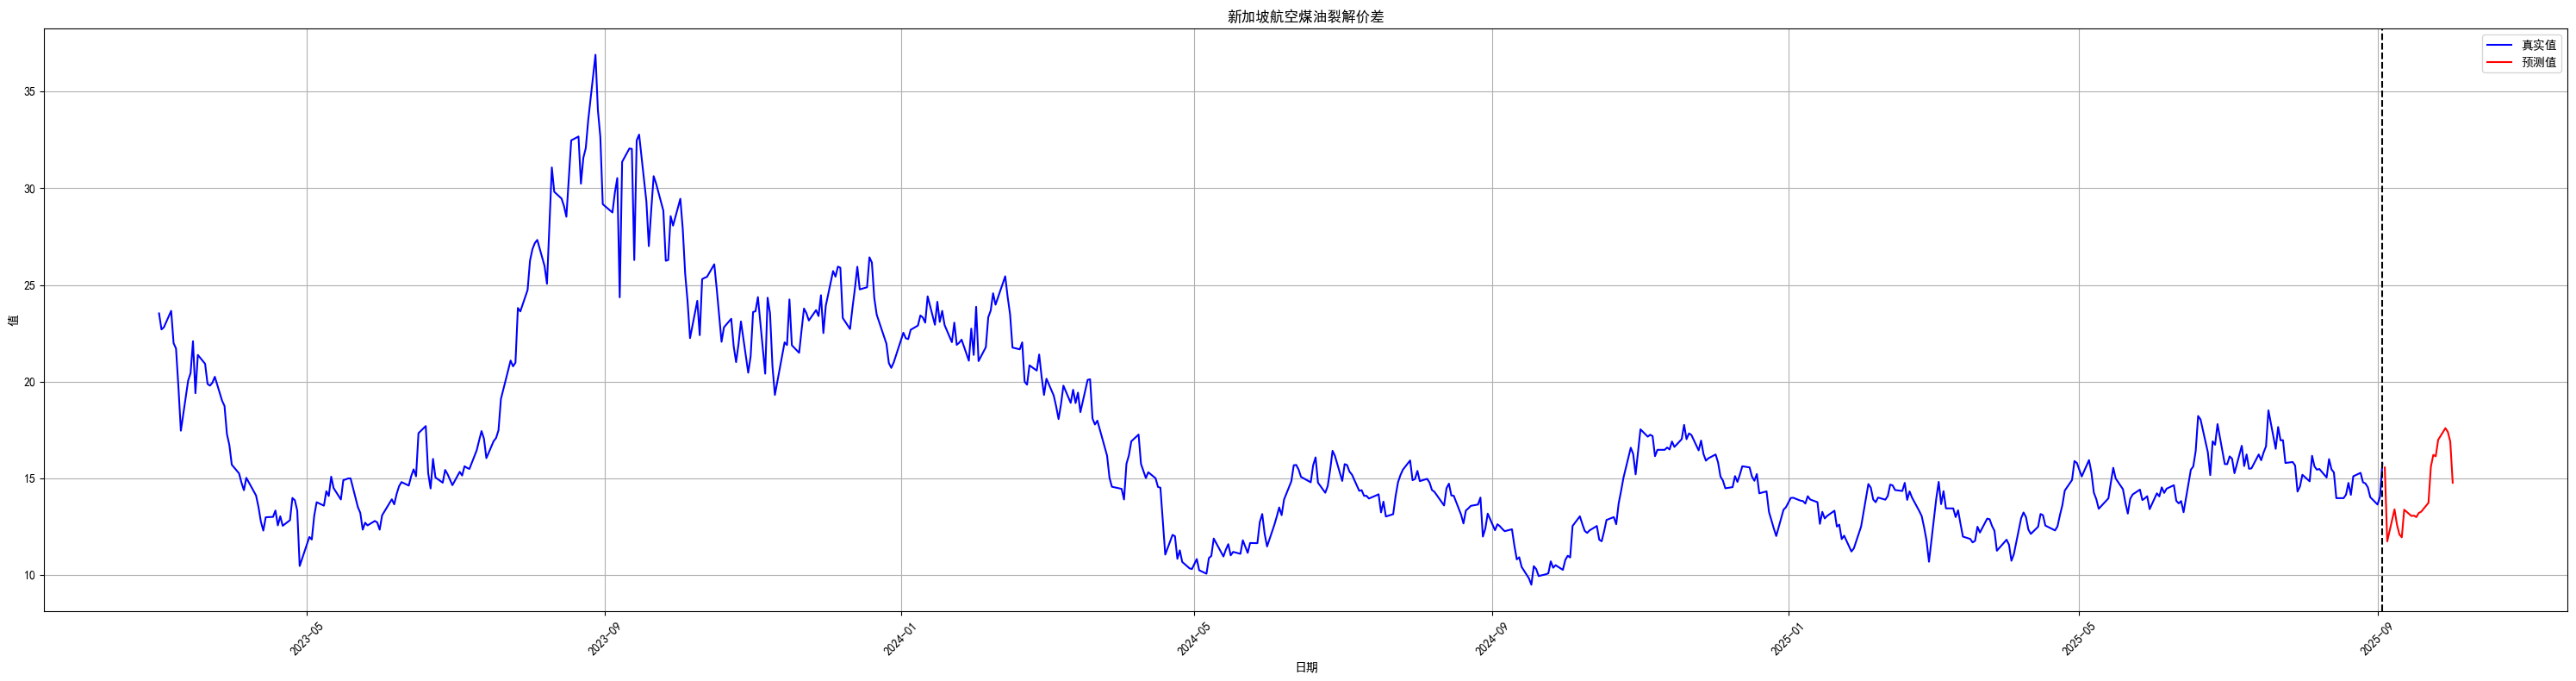

In [11]:
# 设置图形大小
plt.figure(figsize=(30, 8))
merged_df_daily_plot = merged_df_daily
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['新加坡航空煤油裂解价差'], color='blue', label='真实值')
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['新加坡航空煤油裂解价差_预测'], color='red', label='预测值')
avline_date = pd.to_datetime(last_day)
plt.axvline(x=avline_date, color='black', linestyle='--')
plt.legend()
plt.title('新加坡航空煤油裂解价差')
plt.xlabel('日期')
plt.ylabel('值')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "新加坡航空煤油裂解价差"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [13]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "新加坡航空煤油裂解价差"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 22 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/09/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
